In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
import h5py
import obspy
from obspy.signal.filter import envelope
from obspy.clients.fdsn import Client
from glob import glob #is a function that’s used to search for files that match a specific file pattern or name.
import random

from scipy import signal

In [2]:
def extract_waveforms(cat, file_name):
    
    st = []
    cat_trace = cat['trace_name'].values
    for i in range(len(cat_trace)):

            
 
        f = h5py.File(file_name, 'r')
            
            
        bucket = cat['trace_name'].values[i].split('$')[0]
        ind = int(cat['trace_name'].values[i].split('$')[1].split(',')[0])
        # ENZ
        st.append(f['/data/'+bucket][ind, :3, :18000])
        
    return st

def extract_Z_waveforms(cat, file_name):
    
    st = []
    cat_trace = cat['trace_name'].values
    for i in range(len(cat_trace)):

            
 
        f = h5py.File(file_name, 'r')
            
            
        bucket = cat['trace_name'].values[i].split('$')[0]
        ind = int(cat['trace_name'].values[i].split('$')[1].split(',')[0])
        # ENZ
#         st.append(f['/data/'+bucket][ind, 2, :18000])
        waveforms = f['/data/'+bucket][ind, 2, :18000] # Shouldn't this be 3?
        wave = waveforms[np.newaxis, np.newaxis, :]
        st.append(wave)
        
    return st


def convert_into_traces(stream, cat):
    channels = ['BHE','BHN','BHZ'] 
    
    st = []  
    for i in range(len(stream)):
        for j in range(len(stream[i])):
            tr = obspy.Trace(stream[i][j])
            tr.stats.channel = channels[j]
            tr.stats.station = cat['station_code'].values[i]
            tr.stats.network = cat['station_network_code'].values[i]
            tr.stats.sampling_rate = 100
            tr.stats.starttime = obspy.UTCDateTime(cat['trace_start_time'].values[i])
            
            st.append(tr)
            
    return obspy.Stream(st)


def plot_duration_mag(trace, dur_mag, threshold_low=0.02, threshold_high=0.98, title = 'Thunder Waveforms', init_time = 0, final_time = 150):
    
    duration = []
    
    for j in range(len(trace)):
        
            #fig, axs = plt.subplots(2, 1, figsize = (12, 12))
        
            sampling_rate = 100
            d = trace[j].data[init_time*sampling_rate:final_time*sampling_rate]
            t = trace[j].times()[init_time*sampling_rate:final_time*sampling_rate]
            a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)
            lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
            upper_index = np.where(a > a[-1]*(threshold_high))[0][0]
            dur = t[upper_index] - t[lower_index]
            
            duration.append(dur)
    
    plt.figure(figsize=(15,10))
    plt.plot(dur_mag, duration, 'o')
    plt.yscale('log')
    plt.xlabel('Duration Magnitude', fontsize=15)
    plt.ylabel('Duration [s]', fontsize=15)
    plt.title(title, fontsize=20)
            
    # Show the plot
    plt.show()
    return duration

In [3]:
# collecting waveform data and corresponding catalog.
comcat_file_name = "/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5"
comcat_csv_file = "/data/whd01/yiyu_data/PNWML/comcat_metadata.csv"

noise_file_name = "/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5"
noise_csv_file = "/data/whd01/yiyu_data/PNWML/noise_metadata.csv"

In [39]:
## collecting the catalog and storing it. 
cat_comcat = pd.read_csv(comcat_csv_file)
cat_noise = pd.read_csv(noise_csv_file)

In [5]:
# Shuffle the noise data 
cat_noise_shuffle = cat_noise.sample(frac=1)

In [57]:
# Print the first 5 noise data 
cat_noise_shuffle[0:5]

,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time
1053,noise,UW,EH,FL2,--,46.196,-122.352,1378.0,"bucket5$103,:3,:15001",100,2003-10-23T06:44:25.310000Z
2725,noise,UW,EH,CMW,--,48.423,-122.120,1190.0,"bucket4$268,:3,:15001",100,2005-01-03T14:29:09.840000Z
30857,noise,PB,EH,B201,--,46.303,-122.265,990.0,"bucket5$3059,:3,:15001",100,2016-02-02T12:09:19.620000Z
44480,noise,PB,EH,B011,--,48.650,-123.448,22.0,"bucket5$4413,:3,:15001",100,2020-02-13T05:04:29.050000Z
22264,noise,UW,EH,RVC,--,46.944,-121.974,1000.0,"bucket10$2189,:3,:15001",100,2014-11-11T05:39:59.460000Z


In [6]:
## making SNR in correct format
snrs_comcat = []
for i in range(len(cat_comcat['trace_snr_db'])):
    snrs_comcat.append(np.array(cat_comcat['trace_snr_db'].values[i].split('|')).astype('float')[-1])

In [7]:
cat_comcat['snr_final'] = snrs_comcat

In [8]:
cat_earthquake = cat_comcat[cat_comcat['source_type'] == 'earthquake']

In [9]:
cat_earthquake_good = cat_earthquake.sort_values(by = 'snr_final', ascending = False).iloc[0:2000]

In [31]:
array_earthquake = extract_Z_waveforms(cat_earthquake_good, comcat_file_name)
print(array_earthquake[0].T.shape)
array_earthquake = np.concatenate(array_earthquake, axis=0)
print(array_earthquake.shape)


(15001, 1, 1)
(2000, 1, 15001)


In [23]:
np.zeros(2000)

array([0., 0., 0., ..., 0., 0., 0.])

In [51]:
# put the waveform data into an h5 file
with h5py.File('good_earthquake_Z.h5', 'w') as f:
    f.create_dataset('quake', data=array_earthquake)
    

### Making files of earthquakes and durations with an adjusted time window
Recalculate the duration after adjusting the time window and add the durations to the CSV file, deleting the previus durations that I added

In [160]:
array_earthquake = extract_waveforms(cat_earthquake_good, comcat_file_name)
array_earthquake = convert_into_traces(array_earthquake, cat_earthquake_good).select(channel = '*HZ')
init_time = 0
final_time = 150
sampling_rate = 100
t = array_earthquake[0].times()[init_time*sampling_rate:final_time*sampling_rate]
d = array_earthquake[0].data[init_time*sampling_rate:final_time*sampling_rate]
print(t[0:10])
print(d[0:10])
print(len(array_earthquake))


[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09]
[ 0.49821228  0.50241241 -1.49593067 -2.4933665  -1.24082011 -0.48836368
 -0.48609167 -0.73378179 -0.48149201  0.27097946]
2000


In [167]:
trace = array_earthquake[0:5]

In [12]:
np.zeros(2000)

array([0., 0., 0., ..., 0., 0., 0.])

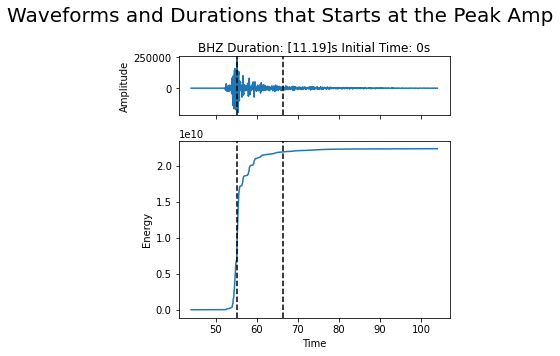

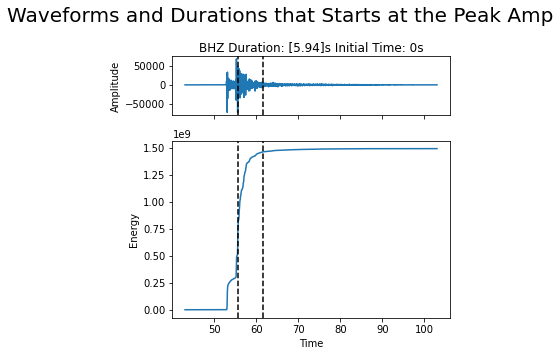

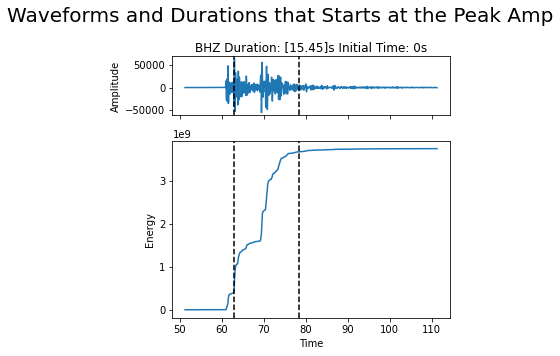

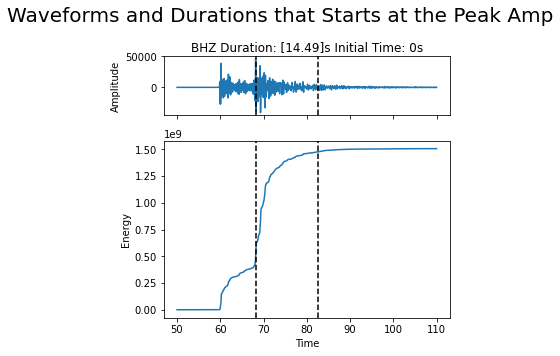

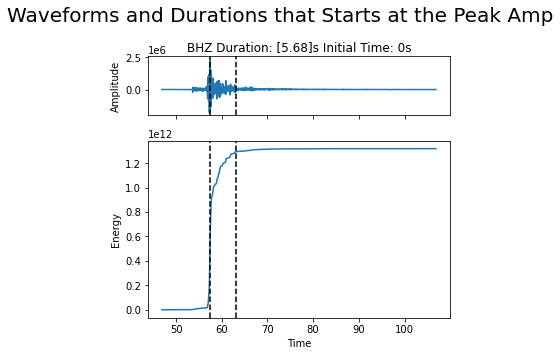

In [169]:
init_time=0
final_time=150 
threshold_low=0.02
threshold_high=0.98
time_before_p=10 
time_after_p=50

duration = []
array = np.zeros((2000, 1, 6000))

for i in range(len(trace)):
    fig, axs = plt.subplots(2, 1, figsize = (5, 5), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)    
        
    sampling_rate = 100
    t = trace[i].times()[init_time*sampling_rate:final_time*sampling_rate]
    d = trace[i].data[init_time*sampling_rate:final_time*sampling_rate]
    a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)   
    
    #Find the P-wave onset
    lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
#     upper_index = np.where(a > a[-1]*(threshold_high))[0][0]
   
    lower_time_index =  lower_index - time_before_p * sampling_rate
    upper_time_index =  lower_index + time_after_p * sampling_rate
    
    new_d = d[lower_time_index:upper_time_index]
    new_t = t[lower_time_index:upper_time_index]
    new_a = a[lower_time_index:upper_time_index]
    
    trace_abs = abs(new_d)
    peak_amp = max(trace_abs)
    peak_amp_index = np.where(trace_abs == peak_amp)

#     lower_index = np.where(new_a > new_a[-1]*(threshold_low))[0][0]
    upper_index = np.where(new_a > new_a[-1]*(threshold_high))[0][0]
    
    dur = new_t[upper_index] - new_t[peak_amp_index]

    duration.append(dur[0])
    
    array[i,0,:] = new_d
    
    # plotting the seismogram
    axs[0].plot(new_t, new_d)
    axs[0].set_ylabel('Amplitude')
#     axs[0].set_xlim(xlim[0], xlim[1])
    axs[0].axvline(new_t[peak_amp_index], ls = '--', color='black')
    axs[0].axvline(new_t[upper_index], ls = '--', color='black')
    axs[0].set_title(trace[i].stats.channel+' '+'Duration: '+str(np.around(dur, 2))+'s'+' '+"Initial Time: 0s")
            
            # plotting the energy curve
    axs[1].plot(new_t, new_a)
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Energy')        
#     axs[1].set_xlim(xlim[0], xlim[1])
    axs[1].axvline(new_t[peak_amp_index], ls = '--', color='black')
    axs[1].axvline(new_t[upper_index], ls = '--', color='black')
        
    fig.suptitle("Waveforms and Durations that Starts at the Peak Amp", fontsize = 20)
    fig.tight_layout()
        
    # Show the plot
    plt.show()

In [152]:
# Add these new durations to highest_snrs_durations_peak_amp.csv
len(duration)
print(len(duration))
print(duration[0:5])

2000
[11.189999999999998, 5.939999999999998, 15.449999999999996, 14.490000000000009, 5.68]


In [166]:
lower_index

5593

In [42]:
cat_earthquake_test = pd.read_csv('highest_snrs_durations_peak_amp.csv')

In [158]:
cat_earthquake_test

,Unnamed: 0.1,Unnamed: 0,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,preferred_source_magnitude_type,...,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset,snr_final,durations,durations_peak_amp
0,0,119605,uw61362346,2018-01-03T08:36:25.940000Z,46.256,-122.056,earthquake,10.230,3.82,ml,...,3.82,0.149,4.20,0.306,NaN,0,0,76.523,12.47,11.19
1,1,58318,uw60563331,2013-08-03T02:11:16.250000Z,46.327,-122.391,earthquake,13.199,3.12,ml,...,3.12,0.275,3.12,0.336,NaN,0,0,73.933,8.47,5.94
2,2,127484,uw61504942,2018-11-19T11:09:13.050000Z,47.698,-123.552,earthquake,39.320,4.08,ml,...,4.08,0.163,4.11,0.349,NaN,0,0,73.801,17.23,15.45
3,3,19376,uw10753338,2008-07-31T05:02:43.130000Z,48.152,-122.748,earthquake,55.880,3.87,ml,...,3.87,0.134,3.89,0.246,NaN,0,0,73.368,22.84,14.49
4,4,73030,uw60881241,2014-09-17T10:06:12.840000Z,47.561,-123.009,earthquake,16.201,3.98,ml,...,3.98,0.176,4.14,0.325,NaN,0,0,73.215,6.16,5.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,8697,uw10656733,2005-07-02T22:39:31.040000Z,48.136,-122.482,earthquake,16.500,2.20,md,...,NaN,NaN,2.20,0.030,NaN,2,0,43.633,20.98,20.56
1996,1996,43232,uw10823553,2011-09-04T04:13:39.540000Z,46.411,-119.260,earthquake,1.605,3.21,ml,...,3.21,0.119,3.70,0.040,NaN,0,0,43.632,14.04,11.16
1997,1997,147871,uw61625752,2020-06-03T17:13:50.350000Z,46.844,-121.762,earthquake,0.310,1.10,ml,...,1.10,0.098,0.29,0.105,NaN,0,0,43.630,3.65,2.85
1998,1998,109477,uw61267487,2017-05-18T18:15:32.560000Z,47.593,-122.589,earthquake,25.110,2.50,ml,...,2.50,0.286,2.57,0.297,NaN,0,0,43.629,9.74,5.69


In [157]:
cat_earthquake_test['durations_peak_amp']=duration

In [159]:
cat_earthquake_test.to_csv('highest_snrs_durations_peak_amp.csv')

In [49]:
# Make an h5 file containing new waveform data
arr_earthquake_downsamp = signal.decimate(array, 5, axis=-1)
print(arr_earthquake_downsamp.shape)

(2000, 1, 1200)


In [50]:
with h5py.File('good_earthquake_Z_20Hz_1min.h5', 'w') as f:
    f.create_dataset('quake', data=arr_earthquake_downsamp)

In [51]:
print(max(duration))

[49.03]


In [52]:
np.argmax(duration)

1950

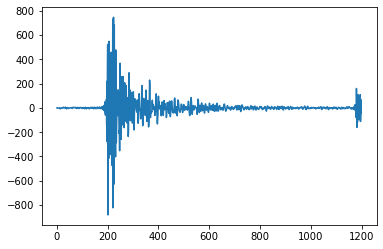

In [53]:
x = np.arange(0, 1200)
plt.plot(x, arr_earthquake_downsamp[1950,0])

### Making files of noise with an adjusted time window


In [59]:
cat_noise_good = cat_noise_shuffle.iloc[0:2000]

In [60]:
len(cat_noise_good)

2000

In [61]:
stream_noise = extract_waveforms(cat_noise_good, noise_file_name)
tr_noise = convert_into_traces(stream_noise, cat_noise_good).select(channel = '*HZ')
print(tr_noise[0:10])

10 Trace(s) in Stream:
UW.FL2..BHZ  | 2003-10-23T06:44:25.310000Z - 2003-10-23T06:46:55.310000Z | 100.0 Hz, 15001 samples
UW.CMW..BHZ  | 2005-01-03T14:29:09.840000Z - 2005-01-03T14:31:39.840000Z | 100.0 Hz, 15001 samples
PB.B201..BHZ | 2016-02-02T12:09:19.620000Z - 2016-02-02T12:11:49.620000Z | 100.0 Hz, 15001 samples
PB.B011..BHZ | 2020-02-13T05:04:29.050000Z - 2020-02-13T05:06:59.050000Z | 100.0 Hz, 15001 samples
UW.RVC..BHZ  | 2014-11-11T05:39:59.460000Z - 2014-11-11T05:42:29.460000Z | 100.0 Hz, 15001 samples
TA.I03D..BHZ | 2013-03-24T19:23:13.640000Z - 2013-03-24T19:25:43.640000Z | 100.0 Hz, 15001 samples
UW.TDL..BHZ  | 2017-10-03T00:55:09.910000Z - 2017-10-03T00:57:39.910000Z | 100.0 Hz, 15001 samples
CC.OBSR..BHZ | 2017-06-12T10:13:29.570000Z - 2017-06-12T10:15:59.570000Z | 100.0 Hz, 15001 samples
UW.RCM..BHZ  | 2008-09-18T18:17:53.620000Z - 2008-09-18T18:20:23.620000Z | 100.0 Hz, 15001 samples
UW.ETW..BHZ  | 2020-11-27T08:10:00.430000Z - 2020-11-27T08:12:30.430000Z | 100.0 Hz, 1

In [ ]:
trace = tr_noise[0:4]

In [77]:
init_time=0
final_time=60 
# threshold_low=0.02
# threshold_high=0.98
# time_before_p=10 
# time_after_p=50

# duration = []
array_noise = np.zeros((2000, 1, 6000))

for i in range(len(trace)):
        
    sampling_rate = 100
    t = trace[i].times()[init_time*sampling_rate:final_time*sampling_rate]
    d = trace[i].data[init_time*sampling_rate:final_time*sampling_rate]
#     a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)   
    
    #Find the P-wave onset
#     lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
#     upper_index = np.where(a > a[-1]*(threshold_high))[0][0]
   
#     lower_time_index =  lower_index - time_before_p * sampling_rate
#     upper_time_index =  lower_index + time_after_p * sampling_rate
    
#     new_d = d[lower_time_index:upper_time_index]
#     new_t = t[lower_time_index:upper_time_index]
#     new_a = a[lower_time_index:upper_time_index]
    
#     trace_abs = abs(new_d)
#     peak_amp = max(trace_abs)
#     peak_amp_index = np.where(trace_abs == peak_amp)

#     lower_index = np.where(new_a > new_a[-1]*(threshold_low))[0][0]
#     upper_index = np.where(new_a > new_a[-1]*(threshold_high))[0][0]
    
#     dur = new_t[upper_index] - new_t[peak_amp_index]

#     duration.append(dur)
    
    array_noise[i,0,:] = d
    
    ## plotting the seismogram
#     axs[0].plot(t, d)
#     axs[0].set_ylabel('Amplitude')
#     axs[0].set_xlim(xlim[0], xlim[1])
#     axs[0].axvline(new_t[peak_amp_index], ls = '--', color='black')
#     axs[0].axvline(new_t[upper_index], ls = '--', color='black')
#     axs[0].set_title(trace[i].stats.channel+' '+'Duration: '+str(np.around(dur, 2))+'s'+' '+"Initial Time: 0s")
            
            # plotting the energy curve
#     axs[1].plot(t, d)
#     axs[1].set_xlabel('Time')
#     axs[1].set_ylabel('Energy')        
#     axs[1].set_xlim(xlim[0], xlim[1])
#     axs[1].axvline(new_t[peak_amp_index], ls = '--', color='black')
#     axs[1].axvline(new_t[upper_index], ls = '--', color='black')
        
#     fig.suptitle("Waveforms and Durations that Starts at the Peak Amp", fontsize = 20)
#     fig.tight_layout()
        
    # Show the plot
#     plt.show()

In [78]:
array_noise[1,0,0:10]

array([-0.99985426, -2.74957067, -2.74869336, -1.99776247, -2.24720127,
       -1.74646567,  0.00450436,  1.00537257,  0.25599346, -1.24339341])

In [79]:
# Make an h5 file containing new waveform data
arr_earthquake_downsamp = signal.decimate(array_noise, 5, axis=-1)
print(arr_earthquake_downsamp.shape)

(2000, 1, 1200)


In [80]:
# Make a file
with h5py.File('shuffled_noise_Z_20Hz_1min.h5', 'w') as f:
    f.create_dataset('noise', data=arr_earthquake_downsamp)

### Normalized the earthquake data and create a file

In [81]:
# Read the waveform data of noise downsampled to 20 Hz
with h5py.File('good_earthquake_Z_20Hz_1min.h5', 'r') as f:
    wave = f['quake'][:] # Add this pair of brakets to extract only the np array
    print(wave.shape)

(2000, 1, 1200)


In [84]:
earthquake_normalized = (wave - np.mean(wave, axis=1, keepdims=True)) / (np.std(wave, axis=1, keepdims=True) + 1e-12)

(array([   0.,    0.,    0.,    0.,    0., 1200.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

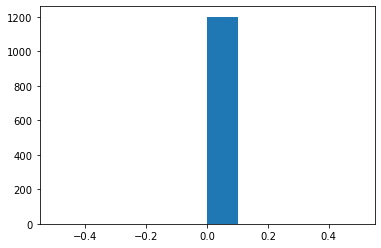

In [85]:
plt.hist(earthquake_normalized[1][0])

In [86]:
earthquake_normalized1 = np.zeros((2000,1,1200))

In [97]:
for i in range(len(wave)):
    earthquake_normalized1[i,0,:] = (wave[i,0,:] - np.mean(wave[i,0,:])) /(np.std(wave[i,0,:])+1e-12)

(array([1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 7.000e+00, 1.080e+02,
        1.067e+03, 8.000e+00, 4.000e+00, 2.000e+00]),
 array([-16.45585033, -13.77389373, -11.09193712,  -8.40998052,
         -5.72802391,  -3.04606731,  -0.3641107 ,   2.3178459 ,
          4.9998025 ,   7.68175911,  10.36371571]),
 <BarContainer object of 10 artists>)

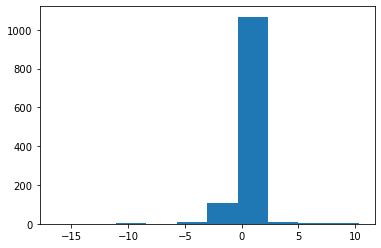

In [100]:
plt.hist(earthquake_normalized1[1222][0])

In [101]:
with h5py.File('earthquake_Z_20Hz_1min_norm.h5', 'w') as f:
    f.create_dataset('quake', data=earthquake_normalized1)

### Normalized the noise data and create a file

In [105]:
# Read the waveform data of noise downsampled to 20 Hz
with h5py.File('shuffled_noise_Z_20Hz_1min.h5', 'r') as f:
    noise = f['noise'][:] # Add this pair of brakets to extract only the np array
    print(noise.shape)

(2000, 1, 1200)


In [104]:
noise_normalized = np.zeros((2000,1,1200))

In [106]:
for i in range(len(noise)):
    noise_normalized[i,0,:] = (noise[i,0,:] - np.mean(noise[i,0,:])) /(np.std(noise[i,0,:])+1e-12)

(array([1.000e+00, 3.000e+00, 1.200e+01, 4.100e+01, 1.121e+03, 1.200e+01,
        9.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-10.54577727,  -8.03246747,  -5.51915766,  -3.00584785,
         -0.49253805,   2.02077176,   4.53408157,   7.04739138,
          9.56070118,  12.07401099,  14.5873208 ]),
 <BarContainer object of 10 artists>)

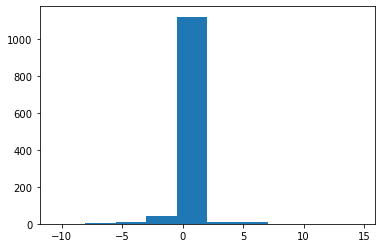

In [112]:
plt.hist(noise_normalized[1][0])

In [113]:
with h5py.File('noise_Z_20Hz_1min_norm.h5', 'w') as f:
    f.create_dataset('noise', data=noise_normalized)

### Mix the earthquake and noise waveform data and make a file

In [120]:
# Read the waveform data of noise 
with h5py.File('earthquake_Z_20Hz_1min_norm.h5', 'r') as f:
    wave = f['quake'][:] # Add this pair of brakets to extract only the np array
    print(wave.shape)

(2000, 1, 1200)


In [28]:
# Read the waveform data of noise 
with h5py.File('noise_Z_20Hz_1min_norm.h5', 'r') as f:
    noise = f['noise'][:] # Add this pair of brakets to extract only the np array
    print(noise.shape)

(2000, 1, 1200)


In [29]:
mixed_signal = np.zeros((2000,1,1200))

In [30]:
for i in range(len(wave)):
    x = np.random.rand()
    mixed_signal[i,0,:]= wave[i,0,:] * x + noise[i,0,:] * (1-x)

(array([1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 7.000e+00, 1.067e+03,
        1.130e+02, 4.000e+00, 2.000e+00, 2.000e+00]),
 array([-11.99884033,  -9.97254753,  -7.94625472,  -5.91996192,
         -3.89366912,  -1.86737632,   0.15891649,   2.18520929,
          4.21150209,   6.23779489,   8.26408769]),
 <BarContainer object of 10 artists>)

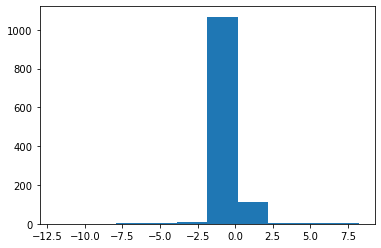

In [38]:
plt.hist(mixed_signal[16,0])

In [125]:
with h5py.File('mixed_signal_1min.h5', 'w') as f:
    f.create_dataset('quake', data=mixed_signal)

### Normalized the mixed data

In [24]:
# Read the waveform data of noise 
with h5py.File('mixed_signal_1min.h5', 'r') as f:
    wave = f['quake'][:] # Add this pair of brakets to extract only the np array
    print(wave.shape)

(2000, 1, 1200)


In [33]:
mixed_signal_normalized = np.zeros((2000,1,1200))

In [34]:
for i in range(len(wave)):
    mixed_signal_normalized[i,0,:] = (wave[i,0,:] - np.mean(wave[i,0,:])) /(np.std(wave[i,0,:])+1e-12)

(array([   2.,    0.,    4.,    6.,    9., 1146.,   20.,    5.,    4.,
           4.]),
 array([-11.87801463,  -9.78755736,  -7.6971001 ,  -5.60664284,
         -3.51618558,  -1.42572832,   0.66472894,   2.7551862 ,
          4.84564347,   6.93610073,   9.02655799]),
 <BarContainer object of 10 artists>)

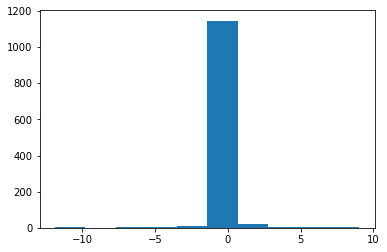

In [35]:
plt.hist(mixed_signal_normalized[12,0])

In [140]:
with h5py.File('mixed_signal_1min_norm.h5', 'w') as f:
    f.create_dataset('quake', data=mixed_signal_normalized)

In [ ]:
# Ignore the codes below

### Make a file of the earthquake data with 15000 samples instead of 15001 which I have formerly been doing

In [10]:
n1 = np.zeros((2000,1,15000))

In [11]:
stream_earthquake = extract_waveforms(cat_earthquake_good, comcat_file_name)
tr_earthquake_Z = convert_into_traces(stream_earthquake, cat_earthquake_good).select(channel = '*HZ')
tr_earthquake_Z[0:5]

5 Trace(s) in Stream:
PB.B202..BHZ | 2018-01-03T08:35:35.940000Z - 2018-01-03T08:38:05.940000Z | 100.0 Hz, 15001 samples
PB.B201..BHZ | 2013-08-03T02:10:26.250000Z - 2013-08-03T02:12:56.250000Z | 100.0 Hz, 15001 samples
PB.B003..BHZ | 2018-11-19T11:08:23.050000Z - 2018-11-19T11:10:53.050000Z | 100.0 Hz, 15001 samples
PB.B943..BHZ | 2008-07-31T05:01:53.130000Z - 2008-07-31T05:04:23.130000Z | 100.0 Hz, 15001 samples
UW.DOSE..BHZ | 2014-09-17T10:05:22.840000Z - 2014-09-17T10:07:52.840000Z | 100.0 Hz, 15001 samples

In [12]:
init_time=0
final_time=150 
threshold_low=0.02
threshold_high=0.98
# time_before_p=10 
# time_after_p=90

trace = tr_earthquake_Z

for i in range(len(trace)):
        
    sampling_rate = 100
    t = trace[i].times()[init_time*sampling_rate:final_time*sampling_rate]
    d = trace[i].data[init_time*sampling_rate:final_time*sampling_rate]
    a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)
    
    n1[i][0][:] = d
    
print(n1.shape)
#     lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
#     upper_index = np.where(a > a[-1]*(threshold_high))[0][0]
#     dur = t[upper_index] - t[lower_index]
#     lower_time_index =  lower_index - time_before_p * sampling_rate
#     upper_time_index =  lower_index + time_after_p * sampling_rate
        
#     new_d = d[lower_time_index:upper_time_index]
#     new_t = t[lower_time_index:upper_time_index]
#     new_a = a[lower_time_index:upper_time_index]

(2000, 1, 15000)


In [14]:
n1[0:3]

array([[[  0.49821228,   0.50241241,  -1.49593067, ...,   4.49202359,
          44.49748751,  62.50504953]],

       [[ -0.99985426,  -2.74957067,  -2.74869336, ...,   4.99765386,
           7.99933512,   5.24945997]],

       [[ -0.9990835 ,  -3.24799687,  -4.49611273, ..., -14.25584162,
          -6.75345258,  -2.75155628]]])

In [17]:
# This file will contain the data with 15000 samples instead of 15001 
with h5py.File('good_earthquake_Z1.h5', 'w') as f:
    f.create_dataset('quake', data=n1)

### Making a file downsampled
Downsample the waveform data from 100 Hz to 20 Hz using a downsampling factor of 5

In [15]:
with h5py.File('good_earthquake_Z.h5', 'r') as f:
    wave = f['quake'][:] # Add this pair of brakets to extract only the np array
    print(wave.shape)

(2000, 1, 15001)


In [16]:
wave[0:5]

array([[[ 0.49821228,  0.50241241, -1.49593067, ..., 44.49748751,
         62.50504953, 27.74875629]],

       [[-0.99985426, -2.74957067, -2.74869336, ...,  7.99933512,
          5.24945997,  0.99960043]],

       [[-0.9990835 , -3.24799687, -4.49611273, ..., -6.75345258,
         -2.75155628, -0.75000794]],

       [[-0.50006335, -1.00033712, -0.50043845, ..., -5.99991596,
         -1.24951938,  0.25023162]],

       [[ 7.88528678, 10.57635546, 12.11379037, ..., 77.18957779,
         46.75678069, 22.82837932]]])

In [19]:
with h5py.File('good_earthquake_Z1.h5', 'r') as f:
    wave1 = f['quake'][:] # Add this pair of brakets to extract only the np array
    print(wave.shape)

(2000, 1, 15000)


In [20]:
arr_earthquake_downsamp1 = signal.decimate(wave1, 5)

In [21]:
print(arr_earthquake_downsamp1.shape)

(2000, 1, 3000)


In [6]:
with h5py.File('good_earthquake_Z_20Hz.h5', 'w') as f:
    f.create_dataset('quake', data=arr_earthquake_downsamp)

In [22]:
with h5py.File('good_earthquake_Z1_20Hz.h5', 'w') as f:
    f.create_dataset('quake', data=arr_earthquake_downsamp1)

### Extract earthquake waveforms of the highest 5000 SNRs
Make sure all waveforms have SNRs higher than 15.

In [10]:
# Take the earthquake data of the highset 5000 waveforms
cat_earthquake_highest_5000 = cat_earthquake.sort_values(by = 'snr_final', ascending = False).iloc[0:5000]

In [11]:
# Make sure the lowest SNR is greater than 15
cat_earthquake_highest_5000

,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,preferred_source_magnitude_type,preferred_source_magnitude_uncertainty,source_depth_uncertainty_km,...,trace_snr_db,source_type_pnsn_label,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset,snr_final
119605,uw61362346,2018-01-03T08:36:25.940000Z,46.256,-122.056,earthquake,10.230,3.82,ml,0.149,0.42,...,70.354|74.938|76.523,eq,3.82,0.149,4.20,0.306,NaN,0,0,76.523
58318,uw60563331,2013-08-03T02:11:16.250000Z,46.327,-122.391,earthquake,13.199,3.12,ml,0.275,0.62,...,78.355|77.278|73.933,eq,3.12,0.275,3.12,0.336,NaN,0,0,73.933
127484,uw61504942,2018-11-19T11:09:13.050000Z,47.698,-123.552,earthquake,39.320,4.08,ml,0.163,0.38,...,61.279|59.563|73.801,eq,4.08,0.163,4.11,0.349,NaN,0,0,73.801
19376,uw10753338,2008-07-31T05:02:43.130000Z,48.152,-122.748,earthquake,55.880,3.87,ml,0.134,0.62,...,61.517|77.406|73.368,eq,3.87,0.134,3.89,0.246,NaN,0,0,73.368
73030,uw60881241,2014-09-17T10:06:12.840000Z,47.561,-123.009,earthquake,16.201,3.98,ml,0.206,0.79,...,69.742|74.111|73.215,eq,3.98,0.176,4.14,0.325,NaN,0,0,73.215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18744,uw10715658,2007-05-14T20:45:55.090000Z,47.688,-120.114,earthquake,4.307,1.70,md,0.080,1.89,...,nan|nan|38.242,eq,NaN,NaN,1.70,0.080,NaN,2,0,38.242
35871,uw10813048,2010-12-17T07:41:24.430000Z,47.733,-122.205,earthquake,22.259,2.48,ml,0.208,0.25,...,39.113|39.895|38.239,eq,2.48,0.208,2.40,0.020,NaN,0,0,38.239
154554,uw61610251,2020-04-19T03:09:02.730000Z,46.843,-121.934,earthquake,6.030,1.39,ml,0.237,0.19,...,nan|nan|38.238,eq,1.39,0.237,0.91,0.219,NaN,2,0,38.238
50597,uw60432427,2012-07-29T22:46:08.590000Z,47.737,-122.001,earthquake,-0.243,1.40,ml,0.213,0.68,...,nan|nan|38.237,eq,1.40,0.213,1.28,0.215,NaN,2,0,38.237


In [12]:
stream_earthquake_highest_5000 = extract_waveforms(cat_earthquake_highest_5000, comcat_file_name)
tr_earthquake_Z_highest_5000 = convert_into_traces(stream_earthquake_highest_5000, cat_earthquake_highest_5000).select(channel = '*HZ')

In [14]:
trace = tr_earthquake_Z_highest_5000

In [15]:
# Find the pre-P time for all the waveforms
init_time=0
final_time=150 
threshold_low=0.02
threshold_high=0.98
time_before_p=10 
time_after_p=50

# pre-P time here is the time between the absolute start time and the P onset time in each trace
pre_p_time = []

for i in range(len(trace)):
    sampling_rate = 100
    t = trace[i].times()[init_time*sampling_rate:final_time*sampling_rate]
    d = trace[i].data[init_time*sampling_rate:final_time*sampling_rate]
    a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)   
    
    #Find the P-wave onset
    lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
    
    pre_p = lower_index - init_time
    
    pre_p_time.append(pre_p/100)
#     upper_index = np.where(a > a[-1]*(threshold_high))[0][0]

(array([7.000e+00, 8.000e+00, 6.000e+00, 4.000e+00, 2.000e+00, 3.209e+03,
        1.589e+03, 1.660e+02, 8.000e+00, 1.000e+00]),
 array([ 1.57 , 10.816, 20.062, 29.308, 38.554, 47.8  , 57.046, 66.292,
        75.538, 84.784, 94.03 ]),
 <BarContainer object of 10 artists>)

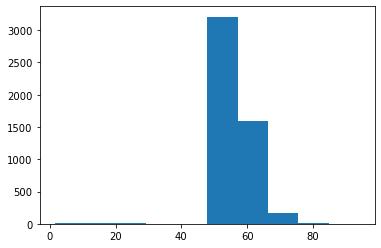

In [16]:
plt.hist(pre_p_time)

In [17]:
print(min(pre_p_time))

1.57


In [18]:
trace = tr_earthquake_Z_highest_5000[0:3]

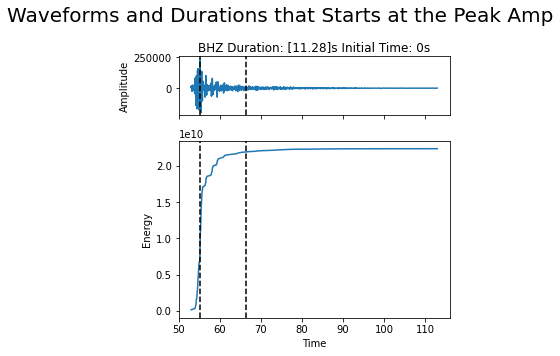

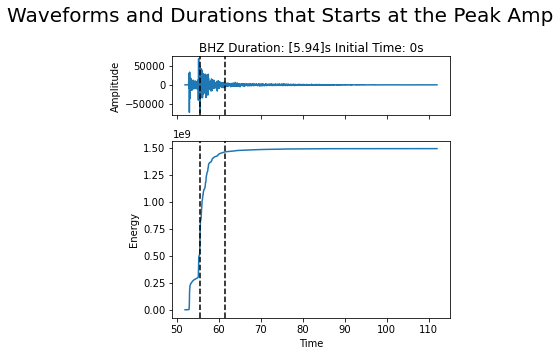

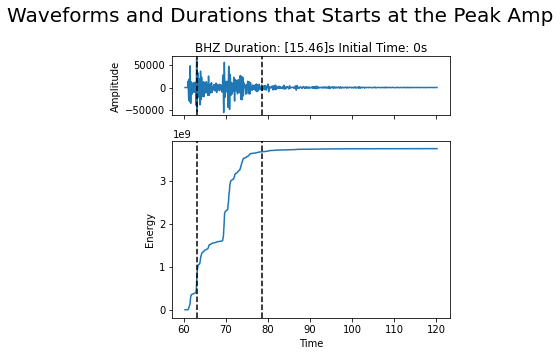

In [22]:
# Contain the thunder waveforms in the zeros. The time before P is 1s 
# since the minimal pre-P time is 1.57.
init_time=0
final_time=150 
threshold_low=0.02
threshold_high=0.98
time_before_p=1
time_after_p=59

duration = []
arr_earthquake_highest_5000 = np.zeros((len(tr_earthquake_Z_highest_5000), 1, 6000))

for i in range(len(trace)):
    fig, axs = plt.subplots(2, 1, figsize = (5, 5), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)    
        
    sampling_rate = 100
    t = trace[i].times()[init_time*sampling_rate:final_time*sampling_rate]
    d = trace[i].data[init_time*sampling_rate:final_time*sampling_rate]
    a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)   
    
    #Find the P-wave onset
    lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
#     upper_index = np.where(a > a[-1]*(threshold_high))[0][0]
   
    lower_time_index =  lower_index - time_before_p * sampling_rate
    upper_time_index =  lower_index + time_after_p * sampling_rate
    
    new_d = d[lower_time_index:upper_time_index]
    new_t = t[lower_time_index:upper_time_index]
    new_a = a[lower_time_index:upper_time_index]
    
    trace_abs = abs(new_d)
    peak_amp = max(trace_abs)
    peak_amp_index = np.where(trace_abs == peak_amp)

#     lower_index = np.where(new_a > new_a[-1]*(threshold_low))[0][0]
    upper_index = np.where(new_a > new_a[-1]*(threshold_high))[0][0]
    
    dur = new_t[upper_index] - new_t[peak_amp_index]

    duration.append(dur[0])
    
    arr_earthquake_highest_5000[i,0,:] = new_d
    
    # plotting the seismogram
    axs[0].plot(new_t, new_d)
    axs[0].set_ylabel('Amplitude')
#     axs[0].set_xlim(xlim[0], xlim[1])
    axs[0].axvline(new_t[peak_amp_index], ls = '--', color='black')
    axs[0].axvline(new_t[upper_index], ls = '--', color='black')
    axs[0].set_title(trace[i].stats.channel+' '+'Duration: '+str(np.around(dur, 2))+'s'+' '+"Initial Time: 0s")
            
            # plotting the energy curve
    axs[1].plot(new_t, new_a)
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Energy')        
#     axs[1].set_xlim(xlim[0], xlim[1])
    axs[1].axvline(new_t[peak_amp_index], ls = '--', color='black')
    axs[1].axvline(new_t[upper_index], ls = '--', color='black')
        
    fig.suptitle("Waveforms and Durations that Starts at the Peak Amp", fontsize = 20)
    fig.tight_layout()
        
    # Show the plot
    plt.show()